In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 数据预处理

In [2]:
data = pd.read_csv('50ETF_OPTION_INFO.csv',sep='\t',encoding='gbk')

In [59]:
data['date'] = pd.to_datetime(data['date'])
data['exercise_date'] = pd.to_datetime(data['exercise_date'])
data['type'] = data['name'].apply(lambda x:x[5])
data = data.sort_values(by='date')

In [4]:
delta_months = []
for i in range(len(data)):
    delta_month = data['exercise_date'].iloc[i].month - data['date'].iloc[i].month
    delta_months.append(delta_month)
data['delta_months'] = delta_months
data['delta_days'] = data['exercise_date'] - data['date']

In [5]:
data2 = data.groupby(data['date'])

## 工具函数

### 计算波动率的调整项：计算远期合约指数，调整sigma值

In [98]:
#计算调整项
def cal_adjusted_sigma(df,tenor,sigma):
    min_k_option = df[df['exercise_price']==min(df['exercise_price'])]
    try:
        if len(min_k_option)>1:
            call_price = min_k_option[min_k_option['type']=='购']['settle_price'].iloc[0]
            put_price = min_k_option[min_k_option['type']=='沽']['settle_price'].iloc[0]
            exercise_price = min_k_option['exercise_price'].iloc[0]
            F = exercise_price + np.exp(-rf*tenor)*(call_price-put_price)
            temp_list = abs(df['exercise_price']-F).tolist()
            F_idx = temp_list.index(min(temp_list))
            k0 = float(df['exercise_price'].iloc[F_idx])
            near_month_sigma = 2.0*(sigma - (F/k0-1)**2)/tenor
        else:
            near_month_sigma = sigma
    except Exception:
        near_month_sigma = sigma
    return near_month_sigma

### 画图函数

In [105]:
def plot(vix_list,name_list):
    etf = pd.read_csv('50ETF报价.csv',sep=',')
    etf['date'] = pd.to_datetime(etf['date'])
    etf_close = etf[etf['date'].isin(name_list)]['close'].tolist()
    df = pd.DataFrame()
    df['date'] = name_list
    df['vix'] = vix_list
    df2 = df[df['date'].isin(etf['date'].tolist())]
    df2['etf_close'] = etf_close
    
    #plot
    fig = plt.figure(figsize=(12,8))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    x = [i for i in range(len(df2))]
    ax1 = fig.add_subplot(111)
    ax1.plot(x,df2['vix'].tolist())
    ax1.set_ylabel('VIX')
    ax2 = ax1.twinx()  # this is the important function
    ax2.plot(x, etf_close, 'r')
    ax2.set_ylabel('50ETF close')
    plt.title('ETF结算价与IVIX')
    return

## 计算VIX

VIX计算的核心公式：
$$\sigma^2 = \frac{2}{T}\sum_{i}\frac{\Delta K_{i}}{K^2_{i}}Q(K_{i})-\frac{1}{T}(\frac{F}{K_{0}}-1)^2$$

其中：

1.$\Delta K_{i}$：对一系列期权按行权价排序，$\Delta K_{i}$是上下两种期权行权价的差值

2.$Q(K_{i})$：看涨或看跌期权的报价，理论上等于期权买价与卖价的平均（考虑数据可得性，本章用结算价替代）

3.$F$：期权价格计算的远期指数，给定某一天不同行权价格的期权信息，其公式为：
$$F = \hat{K} + e^{-rT}(c-p)$$

其中，$\hat{K}$是最低的行权价格，$c$和$p$是对应的看涨/看跌期权价格

算出近月的$\sigma^2$，再用次月的期权合约计算次月的$\sigma^2$，对两者加权即获得VIX，具体如下：
$$VIX=100*\sqrt{(T_1\sigma^2_{1}(\frac{N_2-N_{30}}{N_2-N_1})+(T_2\sigma^2_{2}(\frac{N_{30}-N_1}{N_2-N_1}))*\frac{N_{365}}{N_{30}}}$$

参考了各种资料，下文用不同的$N1$和$N2$计算VIX，并展示了VIX与上证50ETF收盘价的走势图

### 权重处理方法1（结果相对靠谱）

$flag=0$ 时：
$N_{1}=$当前日期距离当月行权日的分钟数，$N_{2}=$当前日期距离次月行权日的分钟数

$flag=1$ 时：
$N_{1}=$当前日期距离次月行权日的分钟数，$N_{2}=$当前日期距离次次月行权日的分钟数


In [102]:
vix_list = []
name_list = []
i=0
for name,group in data2:
    try:
        #关于剩余期限的调整
        temp_months = list(set(group['delta_months'].tolist()))
        temp_months.sort()
        if min(group['delta_days']).days > 7:
            flag = 0
        #如果当月剩余期限小于7天，将期权改为次月和次次月到期的合约
        else:
            flag = 1
        
        temp_df = group[group['delta_months'].isin([temp_months[flag],temp_months[flag+1]])]
        rf = 0.03
        
        
        #近月波动率
        near_month_df = temp_df[temp_df['delta_months'] == temp_months[flag]]
        near_month_tenor = (near_month_df['exercise_date'].iloc[0]-near_month_df['date'].iloc[0]).days/365
        near_month_sigma = near_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*near_month_tenor),axis=1).sum()
        
        #次月波动率
        next_month_df = temp_df[temp_df['delta_months'] == temp_months[flag+1]];
        next_month_tenor = (next_month_df['exercise_date'].iloc[0]-next_month_df['date'].iloc[0]).days/365
        next_month_sigma = next_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*next_month_tenor),axis=1).sum()
        
        #对波动率加权得到VIX指数
        w = (next_month_tenor-30/365)/(next_month_tenor-near_month_tenor)
        vix = 100*np.sqrt(((near_month_tenor*w*near_month_sigma) + (next_month_tenor*(1-w)*next_month_sigma))*365/30)

        vix_list.append(vix)
        name_list.append(name)
        i+=1
    except Exception:
        print("{} doesn't have enough data".format(name))

g:\python\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


2019-06-19 00:00:00 doesn't have enough data
2019-06-20 00:00:00 doesn't have enough data
2019-06-21 00:00:00 doesn't have enough data
2019-06-24 00:00:00 doesn't have enough data
2019-06-25 00:00:00 doesn't have enough data
2019-06-26 00:00:00 doesn't have enough data
2019-06-27 00:00:00 doesn't have enough data
2019-06-28 00:00:00 doesn't have enough data
2019-07-01 00:00:00 doesn't have enough data
2019-07-02 00:00:00 doesn't have enough data
2019-07-03 00:00:00 doesn't have enough data
2019-07-04 00:00:00 doesn't have enough data
2019-07-05 00:00:00 doesn't have enough data
2019-07-08 00:00:00 doesn't have enough data
2019-07-09 00:00:00 doesn't have enough data
2019-07-10 00:00:00 doesn't have enough data
2019-07-11 00:00:00 doesn't have enough data
2019-07-12 00:00:00 doesn't have enough data
2019-07-15 00:00:00 doesn't have enough data
2019-07-16 00:00:00 doesn't have enough data
2019-07-17 00:00:00 doesn't have enough data
2019-07-18 00:00:00 doesn't have enough data
2019-07-19

g:\python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


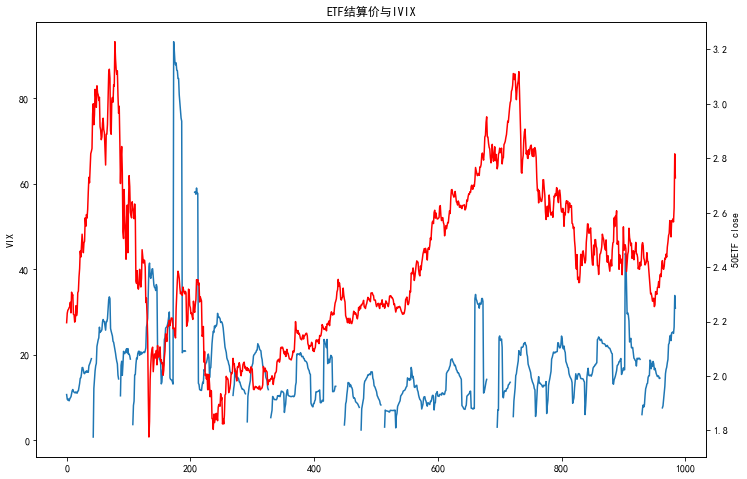

In [107]:
plot(vix_list,name_list)

### 权重处理方法2（折中的方案）

不论$flag$取何值，
$N_{1}=$当前日期距离当月行权日的分钟数，$N_{2}=$当前日期距离次月行权日的分钟数



In [108]:
vix_list2 = []
name_list2 = []
for name,group in data2:
    try:
        #关于剩余期限的调整
        temp_months = list(set(group['delta_months'].tolist()))
        temp_months.sort()
        if min(group['delta_days']).days > 7:
            flag = 0
        #如果当月剩余期限小于7天，将期权改为次月和次次月到期的合约
        else:
            flag = 1
        
        temp_df = group[group['delta_months'].isin([temp_months[flag],temp_months[flag+1]])]

        #近月波动率
        near_month_df = temp_df[temp_df['delta_months'] == temp_months[flag]]
        near_month_tenor = (near_month_df['exercise_date'].iloc[0]-near_month_df['date'].iloc[0]).days/365
        rf = 0.03#可消
        near_month_sigma = near_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*near_month_tenor),axis=1).sum()

        #次月波动率
        next_month_df = temp_df[temp_df['delta_months'] == temp_months[flag+1]];
        next_month_tenor = (next_month_df['exercise_date'].iloc[0]-next_month_df['date'].iloc[0]).days/365
        rf = 0.03#可消
        next_month_sigma = next_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*next_month_tenor),axis=1).sum()

        #对波动率加权得到VIX指数
        
        #==============剩余期限统一算法==========
        temp_df = group[group['delta_months'].isin([temp_months[0],temp_months[1]])]
        near_month_df = temp_df[temp_df['delta_months'] == temp_months[0]]
        N1 = (near_month_df['exercise_date'].iloc[0]-near_month_df['date'].iloc[0]).days
        next_month_df = temp_df[temp_df['delta_months'] == temp_months[1]];
        N2 = (next_month_df['exercise_date'].iloc[0]-next_month_df['date'].iloc[0]).days
        
        w = (N2-30)/(N2-N1)
        vix = 100*np.sqrt(((near_month_tenor*w*near_month_sigma) + (next_month_tenor*(1-w)*next_month_sigma))*365/30)

        vix_list2.append(vix)
        name_list2.append(name)
    except Exception:
        print("{} have no data".format(name))

g:\python\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


2019-06-19 00:00:00 have no data
2019-06-20 00:00:00 have no data
2019-06-21 00:00:00 have no data
2019-06-24 00:00:00 have no data
2019-06-25 00:00:00 have no data
2019-06-26 00:00:00 have no data
2019-06-27 00:00:00 have no data
2019-06-28 00:00:00 have no data
2019-07-01 00:00:00 have no data
2019-07-02 00:00:00 have no data
2019-07-03 00:00:00 have no data
2019-07-04 00:00:00 have no data
2019-07-05 00:00:00 have no data
2019-07-08 00:00:00 have no data
2019-07-09 00:00:00 have no data
2019-07-10 00:00:00 have no data
2019-07-11 00:00:00 have no data
2019-07-12 00:00:00 have no data
2019-07-15 00:00:00 have no data
2019-07-16 00:00:00 have no data
2019-07-17 00:00:00 have no data
2019-07-18 00:00:00 have no data
2019-07-19 00:00:00 have no data
2019-07-22 00:00:00 have no data
2019-07-23 00:00:00 have no data
2019-07-24 00:00:00 have no data
2019-07-25 00:00:00 have no data
2019-07-26 00:00:00 have no data
2019-07-29 00:00:00 have no data
2019-07-30 00:00:00 have no data
2019-07-31

g:\python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


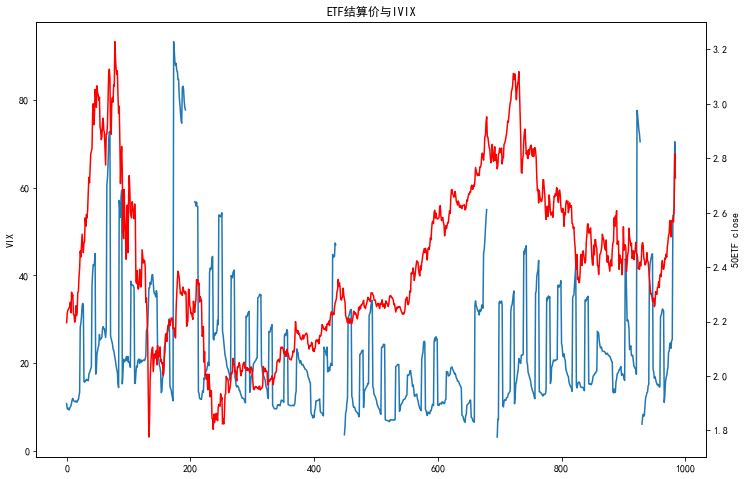

In [109]:
plot(vix_list2,name_list2)

### 权重处理方法3（参考研报）

$N_{1}=$近期合约距离到期月份的分钟数，$N_{2}=$次近期合约距离到期月份的分钟数

In [110]:
vix_list3 = []
name_list3 = []
for name,group in data2:
    try:
        #关于剩余期限的调整
        temp_months = list(set(group['delta_months'].tolist()))
        temp_months.sort()
        if min(group['delta_days']).days > 7:
            flag = 0
        #如果当月剩余期限小于7天，将期权改为次月和次次月到期的合约
        else:
            flag = 1
        
        temp_df = group[group['delta_months'].isin([temp_months[flag],temp_months[flag+1]])]

        #近月波动率
        near_month_df = temp_df[temp_df['delta_months'] == temp_months[flag]]
        near_month_tenor = (near_month_df['exercise_date'].iloc[0]-near_month_df['date'].iloc[0]).days/365
        rf = 0.03#可消
        near_month_sigma = near_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*near_month_tenor),axis=1).sum()

        #次月波动率
        next_month_df = temp_df[temp_df['delta_months'] == temp_months[flag+1]];
        next_month_tenor = (next_month_df['exercise_date'].iloc[0]-next_month_df['date'].iloc[0]).days/365
        rf = 0.03#可消
        next_month_sigma = next_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*next_month_tenor),axis=1).sum()

        #对波动率加权得到VIX指数
        N1 = near_month_tenor*365 + near_month_df['exercise_date'].iloc[0].day
        N2 = next_month_tenor*365 + next_month_df['exercise_date'].iloc[0].day
        w = (N2-30)/(N2-N1)
        vix = 100*np.sqrt(((near_month_tenor*w*near_month_sigma) + (next_month_tenor*(1-w)*next_month_sigma))*365/30)

        vix_list3.append(vix)
        name_list3.append(name)
    except Exception:
        print("{} doesn't have enough data".format(name))

g:\python\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


2019-06-19 00:00:00 doesn't have enough data
2019-06-20 00:00:00 doesn't have enough data
2019-06-21 00:00:00 doesn't have enough data
2019-06-24 00:00:00 doesn't have enough data
2019-06-25 00:00:00 doesn't have enough data
2019-06-26 00:00:00 doesn't have enough data
2019-06-27 00:00:00 doesn't have enough data
2019-06-28 00:00:00 doesn't have enough data
2019-07-01 00:00:00 doesn't have enough data
2019-07-02 00:00:00 doesn't have enough data
2019-07-03 00:00:00 doesn't have enough data
2019-07-04 00:00:00 doesn't have enough data
2019-07-05 00:00:00 doesn't have enough data
2019-07-08 00:00:00 doesn't have enough data
2019-07-09 00:00:00 doesn't have enough data
2019-07-10 00:00:00 doesn't have enough data
2019-07-11 00:00:00 doesn't have enough data
2019-07-12 00:00:00 doesn't have enough data
2019-07-15 00:00:00 doesn't have enough data
2019-07-16 00:00:00 doesn't have enough data
2019-07-17 00:00:00 doesn't have enough data
2019-07-18 00:00:00 doesn't have enough data
2019-07-19

g:\python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


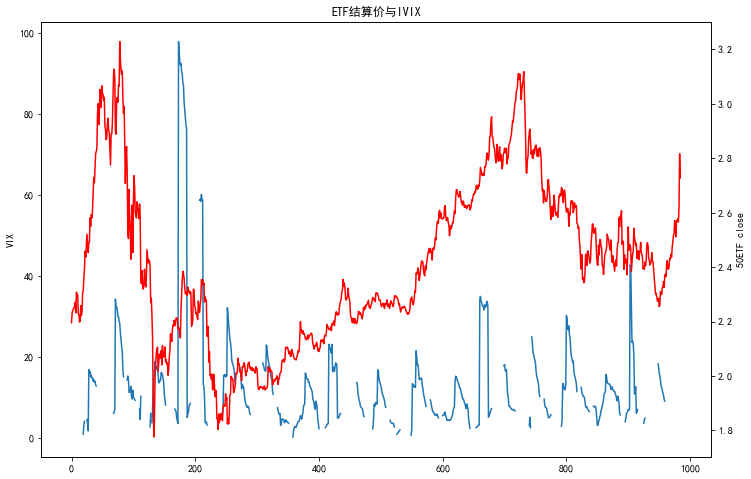

In [111]:
plot(vix_list3,name_list3)

### 引入波动率的调整项（趋势更准确，数值偏差大）

In [112]:
vix_list4 = []
name_list4 = []
i=0
for name,group in data2:
    try:
        #关于剩余期限的调整
        temp_months = list(set(group['delta_months'].tolist()))
        temp_months.sort()
        if min(group['delta_days']).days > 7:
            flag = 0
        #如果当月剩余期限小于7天，将期权改为次月和次次月到期的合约
        else:
            flag = 1
        
        temp_df = group[group['delta_months'].isin([temp_months[flag],temp_months[flag+1]])]
        rf = 0.03
        
        
        #近月波动率
        near_month_df = temp_df[temp_df['delta_months'] == temp_months[flag]]
        near_month_tenor = (near_month_df['exercise_date'].iloc[0]-near_month_df['date'].iloc[0]).days/365
        near_month_sigma = near_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*near_month_tenor),axis=1).sum()
        near_month_sigma = cal_adjusted_sigma(near_month_df,near_month_tenor,near_month_sigma)
        
        #次月波动率
        next_month_df = temp_df[temp_df['delta_months'] == temp_months[flag+1]];
        next_month_tenor = (next_month_df['exercise_date'].iloc[0]-next_month_df['date'].iloc[0]).days/365
        next_month_sigma = next_month_df.apply(lambda df: (0.05/df['exercise_price']**2)*df['settle_price']*np.exp(-rf*next_month_tenor),axis=1).sum()
        next_month_sigma = cal_adjusted_sigma(next_month_df,next_month_tenor,next_month_sigma)
        
        #对波动率加权得到VIX指数
        w = (next_month_tenor-30/365)/(next_month_tenor-near_month_tenor)
        vix = 100*np.sqrt(((near_month_tenor*w*near_month_sigma) + (next_month_tenor*(1-w)*next_month_sigma))*365/30)

        vix_list4.append(vix)
        name_list4.append(name)
        i+=1
    except Exception:
        print("{} doesn't have enough data".format(name))

g:\python\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
g:\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
g:\python\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


2019-06-19 00:00:00 doesn't have enough data
2019-06-20 00:00:00 doesn't have enough data
2019-06-21 00:00:00 doesn't have enough data
2019-06-24 00:00:00 doesn't have enough data
2019-06-25 00:00:00 doesn't have enough data
2019-06-26 00:00:00 doesn't have enough data
2019-06-27 00:00:00 doesn't have enough data
2019-06-28 00:00:00 doesn't have enough data
2019-07-01 00:00:00 doesn't have enough data
2019-07-02 00:00:00 doesn't have enough data
2019-07-03 00:00:00 doesn't have enough data
2019-07-04 00:00:00 doesn't have enough data
2019-07-05 00:00:00 doesn't have enough data
2019-07-08 00:00:00 doesn't have enough data
2019-07-09 00:00:00 doesn't have enough data
2019-07-10 00:00:00 doesn't have enough data
2019-07-11 00:00:00 doesn't have enough data
2019-07-12 00:00:00 doesn't have enough data
2019-07-15 00:00:00 doesn't have enough data
2019-07-16 00:00:00 doesn't have enough data
2019-07-17 00:00:00 doesn't have enough data
2019-07-18 00:00:00 doesn't have enough data
2019-07-19

g:\python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


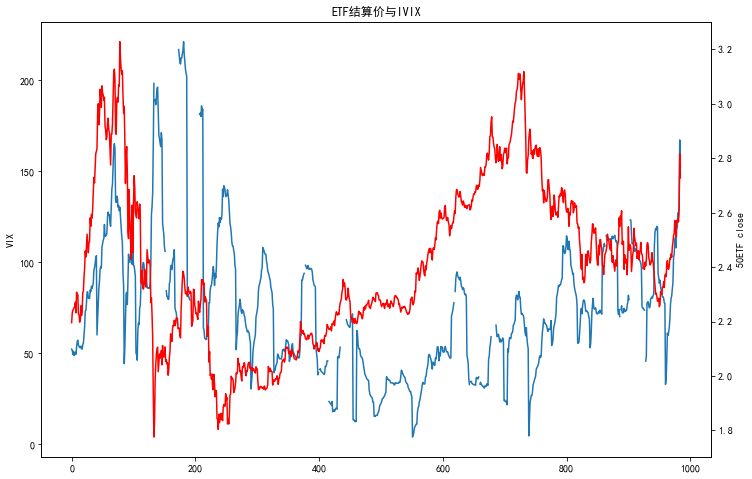

In [113]:
plot(vix_list4,name_list4)